# SDSSJ1908+3940

In [107]:
import json,urllib,glob,os
from zipfile import ZipFile
from math import ceil
from astropy.timeseries import LombScargle
from astropy.timeseries import TimeSeries

from astropy.time import Time

import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
from lightkurve.lightcurve import LightCurve as LC
from lightkurve import TessTargetPixelFile
from astropy.wcs import WCS
import eleanor

from bokeh.plotting import output_notebook, figure, show
from bokeh.models import HoverTool, tools,ColumnDataSource, Whisker, ColorBar, LinearColorMapper
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from bokeh.palettes import viridis, inferno
output_notebook()

#From https://github.com/bokeh/bokeh/issues/3347
def big_palette(size, palette_func):
    if size < 256:
        return palette_func(size)
    p = palette_func(256)
    out = []
    for i in range(size):
        idx = int(i * 256.0 / size)
        out.append(p[idx])
    return out



Loading BokehJS ...

In [2]:
name = 'SDSSJ1908+3940'
with open('response.json','r') as JSON:
    rdic = json.load(JSON)
sourcetess = rdic[name]

sourcetess['ra']
sourcecoord = "{} +{}".format(sourcetess['ra'],sourcetess['dec'])
print(sourcecoord)



lk.search_tesscut(sourcecoord)


287.071125 +39.67677777777777


SearchResult containing 1 data products.

         target_name          productFilename         description         distance
----------------------------- --------------- --------------------------- --------
287.071125 +39.67677777777777             n/a TESS FFI Cutout (sector 14)      0.0

# First Sector

In [3]:
sectornum = 14
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)

url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={ra}&dec={dec}&y=11&x=11&units=px&sector={sector}".format(ra=sourcetess['ra']
,dec=sourcetess['dec']
,sector=sectornum)
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)
response = urllib.request.urlretrieve(url,'TESSCUT.zip')
with ZipFile('TESSCUT.zip') as zipobj:
    zipobj.extractall()
    
for i in glob.glob('tess-s*.fits'):
    os.rename(i,'astrocut.fits')
    tpf = lk.TessTargetPixelFile('astrocut.fits')
    os.remove('astrocut.fits')
    os.remove('TESSCUT.zip')

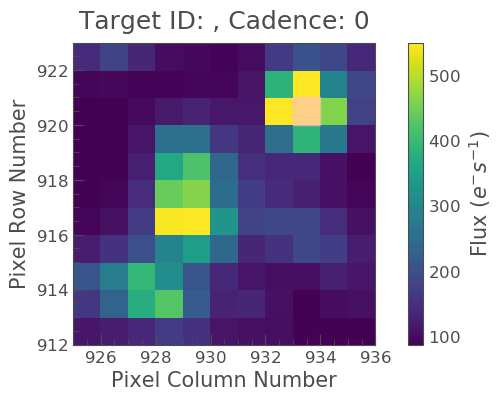

In [4]:
# Guess closest pixel
radecs = np.vstack([[tpf.ra], [tpf.dec]]).T
coords = tpf.wcs.all_world2pix(radecs, 0)

x=coords[:, 0]+tpf.column
x1=coords[:, 0]

y=coords[:, 1]+tpf.row
y1 = coords[:, 1]


masknear = np.zeros([11,11])
masknear[ceil(x1)][ceil(y1)] = 1.
maskneartoplot = masknear.astype(bool)
tpf.plot(aperture_mask=maskneartoplot)

# Guess closest Pixel

In [5]:
#If eleanor mask was found can do aperture_mask=data.aperture.astype(bool)

sourcelc = '{}Sector{}withBKLC.fits'.format(name,tpf.sector)
#tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc)
#tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc,aperture_mask=np.flip(dataeleanor.aperture.astype(bool),0))
tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc,aperture_mask=maskneartoplot)

In [6]:
tpf.interact_sky(magnitude_limit=20) 

In [7]:
background_mask = ~tpf.create_threshold_mask(threshold=0.0000001, reference_pixel=None)
#tpf.plot(aperture_mask=background_mask, mask_color='w');
n_background_pixels = background_mask.sum()
#print(n_background_pixels)
backgroundlc = '{}Sector{}BKLC.fits'.format(name,tpf.sector)

tpf.interact(notebook_url='localhost:8888',exported_filename=backgroundlc,aperture_mask=background_mask)

## Create a light-curve

Number of Background Pixels: 53


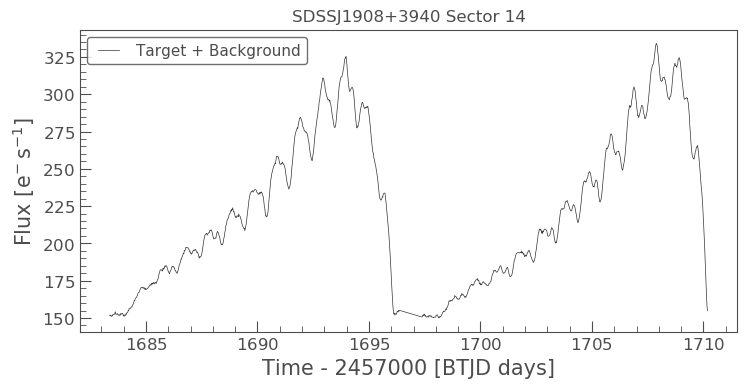

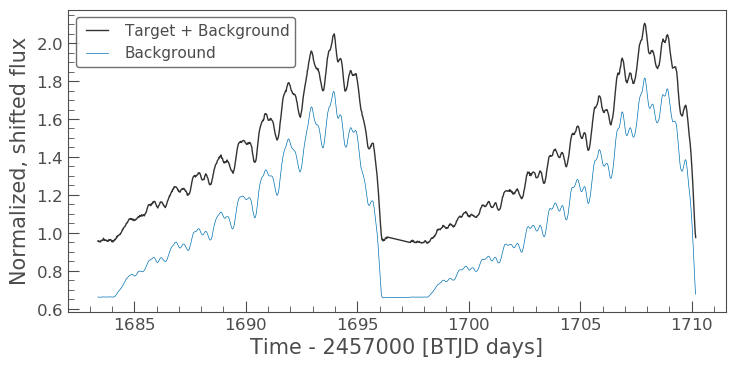

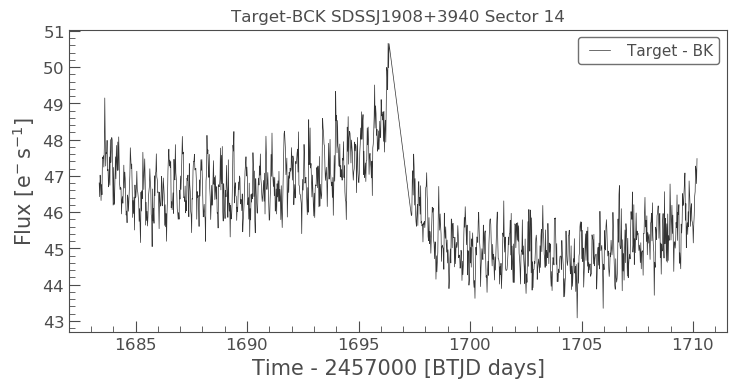

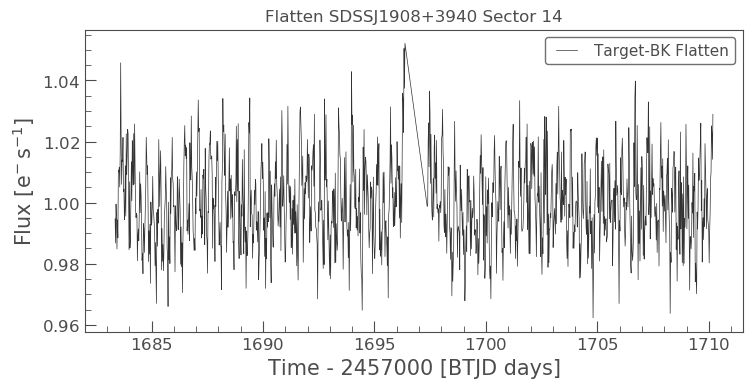

In [8]:
sourcemaskfits = fits.open(sourcelc)
sourcemask = sourcemaskfits[2].data
n_target_pixels = len(np.where(sourcemask==3)[0])

target_lc = tpf.to_lightcurve(aperture_mask=sourcemask)
target_lc.plot(label='Target + Background')
titleplot1 = '{} Sector {}'.format(name,sectornum)
plt.title(titleplot1)


#Backgorund
backgroundmaskfits = fits.open(backgroundlc)
backgroundmask = backgroundmaskfits[2].data
n_background_pixels = len(np.where(backgroundmask==3)[0])
background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=backgroundmask) / n_background_pixels
print("Number of Background Pixels: {}".format(n_background_pixels))
background_estimate_lc = background_lc_per_pixel * n_target_pixels

# Substrtact background
common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(background_estimate_lc / common_normalization +0).plot(ax=ax, normalize=False, label='Background',
                                                        ylabel='Normalized, shifted flux');


corrected_lc = target_lc - background_estimate_lc.flux
corrected_lc.plot(label='Target - BK');
plt.title('Target-BCK {} Sector {}'.format(name,sectornum))


#Remove low frequenbce
flat_lc = corrected_lc.flatten(window_length=401)
flat_lc.plot(label='Target-BK Flatten');
plt.title('Flatten {} Sector {}'.format(name,sectornum))



#Bokeh 
lcdic = {'time':corrected_lc.time,
        "flatflux":corrected_lc.flux}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)


# With Eleanor

# Eleanor and tess y axis are flipped

/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/targetdata.py:383: UserWarning: WARNING: Making a TPF smaller than (9,9) may provide inadequate results.
  warnings.warn('WARNING: Making a TPF smaller than (9,9) may provide inadequate results.')
/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/targetdata.py:393: UserWarning: WARNING: Making a TPF smaller than (9,9) may provide inadequate results.
  warnings.warn('WARNING: Making a TPF smaller than (9,9) may provide inadequate results.')


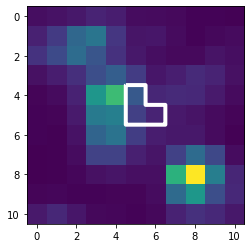

/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/numpy/core/fromnumeric.py:745: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/visualize.py:214: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


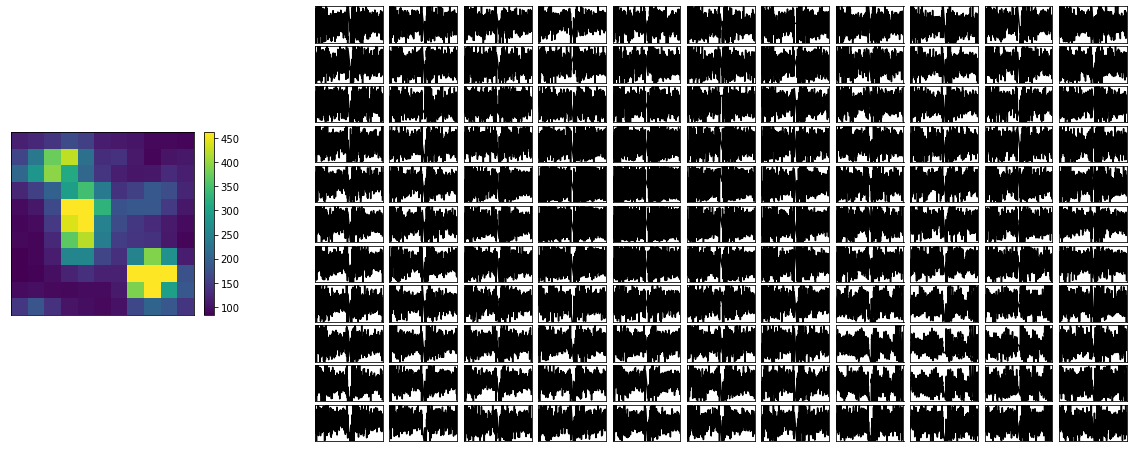

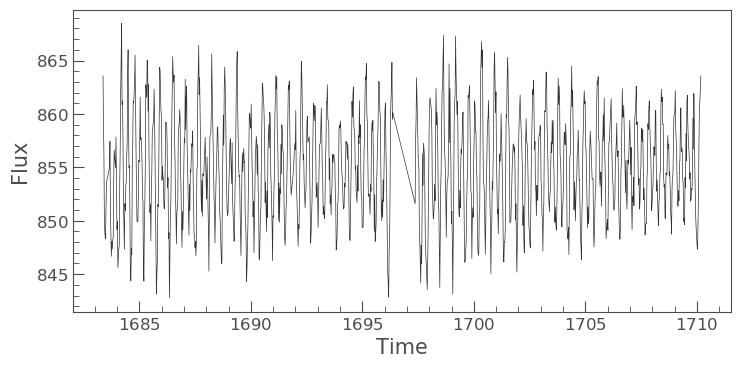

In [9]:
sectornum = 14
star = eleanor.Source(coords=(sourcetess['ra'],sourcetess['dec']), sector=sectornum, tc=True)
dataeleanor = eleanor.TargetData(star,height=11, width=11)

vis = eleanor.Visualize(dataeleanor)
vis.aperture_contour()

fig = vis.pixel_by_pixel()

q = dataeleanor.quality == 0
lkeleanor = LC(dataeleanor.time[q], dataeleanor.corr_flux[q]).plot()

#Bokeh 
lcdic = {'time':dataeleanor.time[q],
        "flatflux":dataeleanor.corr_flux[q]}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Eleanor Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)

# Periodogram

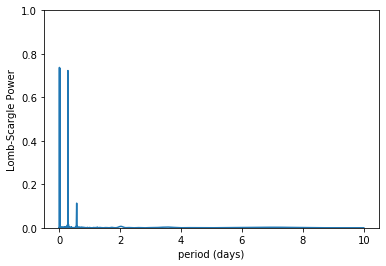

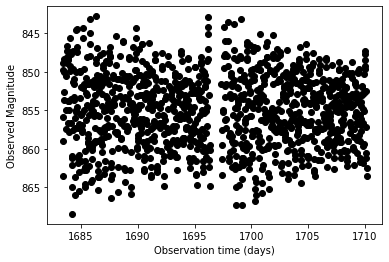

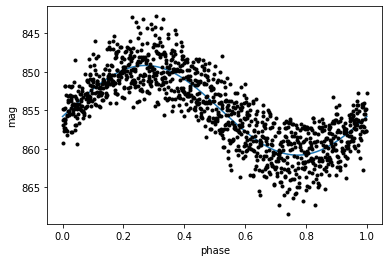

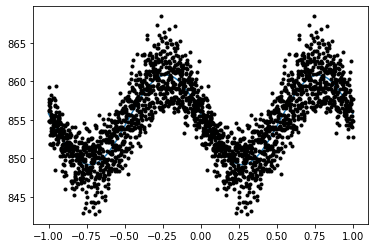

In [136]:

mjd = dataeleanor.time[q]

mag = dataeleanor.corr_flux[q]



freq, PLS = LombScargle(mjd, mag).autopower(minimum_frequency=1 / 10.,
                                                maximum_frequency=1 / 0.01)


best_freq = freq[np.argmax(PLS)]
phase = (mjd * best_freq) % 1

# compute the best-fit model
phase_fit = np.linspace(0, 1,len(mjd))
mag_fit = LombScargle(mjd, mag).model(t=phase_fit / best_freq,
                                          frequency=best_freq)
# plot the periodogram

fig, ax = plt.subplots()

plt.plot(1. / freq, PLS)
ax.set(xlabel='period (days)',
          ylabel='Lomb-Scargle Power',
          ylim=(0, 1));
plt.show()


fig, ax = plt.subplots()

# plot the raw data
ax.errorbar(mjd, mag, fmt='ok', elinewidth=1.5, capsize=0)
ax.invert_yaxis()
ax.set(   xlabel='Observation time (days)',
          ylabel='Observed Magnitude')

#plt.plot(t,mag_fit)



fig, ax = plt.subplots()
# plot the phased data & model in the inset
plt.errorbar(phase, mag, fmt='.k', capsize=0)
plt.plot(phase_fit, mag_fit)


ax.invert_yaxis()
ax.set_xlabel('phase')
ax.set_ylabel('mag')
plt.show()


#Two phases

phase2 = phase-1
phasesall= np.concatenate((phase2, phase), axis=None)
magall = np.concatenate((mag,mag),axis=None)

# compute the best-fit model
phase_fit2 = np.linspace(-1, 1,len(mjd))
mag_fit2 = LombScargle(mjd, mag).model(t=phase_fit2 / best_freq,
                                          frequency=best_freq)


fig, ax = plt.subplots()
# plot the phased data & model in the inset
plt.errorbar(phasesall, magall, fmt='.k', capsize=0);
plt.plot(phase_fit2, mag_fit2);


In [150]:
mjd = dataeleanor.time[q]

mag = dataeleanor.corr_flux[q]



freq, PLS = LombScargle(mjd, mag).autopower(minimum_frequency=1 / 1.,
                                                maximum_frequency=1 / 0.01)

best_freq = freq[np.argmax(PLS)]

summary = 'Best_frequency: {}, Period: {} days'.format(best_freq,1/best_freq)
print(summary)
p1 = figure(plot_width=900, plot_height=500, title=summary,active_drag='pan', active_scroll='wheel_zoom',y_axis_label='Power',x_axis_label='Period (days)')
p2 = figure(plot_width=900, plot_height=500, title='',active_drag='pan', active_scroll='wheel_zoom',y_axis_label='Power',x_axis_label='Freq (1/days)')


#source1 = ColumnDataSource(data={'power':PLS,
#                              'period': 1./freq})

period = 1./freq
source1 = ColumnDataSource(data={'power':PLS,
                              'period':1./freq,
                                'freq':freq})

#Tool to get wavelength
hover1 = HoverTool(
        tooltips=[
            ('Period', '(@period{0.0000000}'),
            ('Frequency', '(@freq{0.00000})')
        ]
    )


p1.add_tools(hover1)
p2.add_tools(hover1)



# add a circle renderer with a size, color, and alpha

p1.line('period','power',source=source1)
p2.line('freq','power',source=source1)

show(p1)
show(p2)



Best_frequency: 92.53254115931193, Period: 0.010807008944867455 days


In [153]:
best_freq = freq[np.argmax(PLS)]
#best_freq = 1/0.5768419


summary = 'Best_frequency: {}, Period: {} days, {} Minutes'.format(best_freq,1/best_freq,1/best_freq*24*60.)


phase = (mjd * best_freq) % 1

# compute the best-fit model
phase_fit = np.linspace(0, 1,len(mjd))
mag_fit = LombScargle(mjd, mag).model(t=phase_fit / best_freq,
                                          frequency=best_freq)
#Two phases

phase2 = phase-1
phasesall= np.concatenate((phase2, phase), axis=None)
magall = np.concatenate((mag,mag),axis=None)
mjdall =  np.concatenate((mjd,mjd),axis=None)


# compute the best-fit model
phase_fit2 = np.linspace(-1, 1,len(mjd))
mag_fit2 = LombScargle(mjd, mag).model(t=phase_fit2 / best_freq,
                                          frequency=best_freq)



my_palette = big_palette(len(mag),viridis)
colorlist = my_palette


p = figure(plot_width=900, plot_height=500, title=summary,active_drag='pan'
           , active_scroll='wheel_zoom',y_axis_label='flux',x_axis_label='Phase')


source = ColumnDataSource(data={'phase':phasesall,
                                'flux':magall,
                                'mjd':mjdall })
  


#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@mjd{0.0000})')
        ]
    )


p.add_tools(hover2)


# add a circle renderer with a size, color, and alpha
#p.add_layout(
#    Whisker(source=source, base="phase", upper="upper", lower="lower")
#)

p.line(phase_fit2, mag_fit2,color='red')
#p.y_range.flipped = True

mapper = LinearColorMapper(palette=colorlist, low=mjdall.min(), high=mjdall.max())

#mapper.low_color = 'blue'
#mapper.high_color = 'red'

color_bar = ColorBar(color_mapper=mapper, location=(0, 0.5),title='MJD')

p.circle('phase','flux',source=source,color={'field': 'mjd', 'transform': mapper})


p.add_layout(color_bar, 'right')
#@date{%F}'

show(p)

In [135]:
mjdall.min()

1683.3677764782265

# Sector 

In [128]:
sectornum = 
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)

url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={ra}&dec={dec}&y=11&x=11&units=px&sector={sector}".format(ra=sourcetess['ra']
,dec=sourcetess['dec']
,sector=sectornum)
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)
response = urllib.request.urlretrieve(url,'TESSCUT.zip')
with ZipFile('TESSCUT.zip') as zipobj:
    zipobj.extractall()
    
for i in glob.glob('tess-s*.fits'):
    os.rename(i,'astrocut.fits')
    tpf = lk.TessTargetPixelFile('astrocut.fits')
    os.remove('astrocut.fits')
    os.remove('TESSCUT.zip')
    

In [ ]:
# Guess closest pixel
radecs = np.vstack([[tpf.ra], [tpf.dec]]).T
coords = tpf.wcs.all_world2pix(radecs, 0)

x=coords[:, 0]+tpf.column
x1=coords[:, 0]

y=coords[:, 1]+tpf.row
y1 = coords[:, 1]


masknear = np.zeros([11,11])
masknear[ceil(x1)][ceil(y1)] = 1.
maskneartoplot = masknear.astype(bool)
tpf.plot(aperture_mask=maskneartoplot)

In [ ]:
#If eleanor mask was found can do aperture_mask=data.aperture.astype(bool)

sourcelc = '{}Sector{}withBKLC.fits'.format(name,tpf.sector)
#tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc)
tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc,aperture_mask=maskneartoplot)

In [ ]:
tpf.interact_sky(magnitude_limit=20)

In [ ]:
background_mask = ~tpf.create_threshold_mask(threshold=0.0000001, reference_pixel=None)
#tpf.plot(aperture_mask=background_mask, mask_color='w');
n_background_pixels = background_mask.sum()
#print(n_background_pixels)
backgroundlc = '{}Sector{}BKLC.fits'.format(name,tpf.sector)

tpf.interact(notebook_url='localhost:8888',exported_filename=backgroundlc,aperture_mask=background_mask)

## Create a light-curve

In [ ]:
sourcemaskfits = fits.open(sourcelc)
sourcemask = sourcemaskfits[2].data
n_target_pixels = len(np.where(sourcemask==3)[0])

target_lc = tpf.to_lightcurve(aperture_mask=sourcemask)
target_lc.plot(label='Target + Background')
titleplot1 = '{} Sector {}'.format(name,sectornum)
plt.title(titleplot1)


#Backgorund
backgroundmaskfits = fits.open(backgroundlc)
backgroundmask = backgroundmaskfits[2].data
n_background_pixels = len(np.where(backgroundmask==3)[0])
background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=backgroundmask) / n_background_pixels
print("Number of Background Pixels: {}".format(n_background_pixels))
background_estimate_lc = background_lc_per_pixel * n_target_pixels

# Substrtact background
common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(background_estimate_lc / common_normalization +0).plot(ax=ax, normalize=False, label='Background',
                                                        ylabel='Normalized, shifted flux');


corrected_lc = target_lc - background_estimate_lc.flux
corrected_lc.plot(label='Target - BK');
plt.title('Target-BCK {} Sector {}'.format(name,sectornum))


#Remove low frequenbce
flat_lc = corrected_lc.flatten(window_length=401)
flat_lc.plot(label='Target-BK Flatten');
plt.title('Flatten {} Sector {}'.format(name,sectornum))



#Bokeh 
lcdic = {'time':corrected_lc.time,
        "flatflux":corrected_lc.flux}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)


# With Eleanor

# Eleanor and tess y axis are flipped

In [ ]:
sectornum = 15
star = eleanor.Source(coords=(sourcetess['ra'],sourcetess['dec']), sector=sectornum, tc=True)
dataeleanor = eleanor.TargetData(star,height=11, width=11)

vis = eleanor.Visualize(dataeleanor)
vis.aperture_contour()

fig = vis.pixel_by_pixel()

q = dataeleanor.quality == 0
lkeleanor = LC(dataeleanor.time[q], dataeleanor.corr_flux[q]).plot()

#Bokeh 
lcdic = {'time':dataeleanor.time[q],
        "flatflux":dataeleanor.corr_flux[q]}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Eleanor Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)

# Other Sector

In [ ]:
sectornum = 
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)

url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={ra}&dec={dec}&y=11&x=11&units=px&sector={sector}".format(ra=sourcetess['ra']
,dec=sourcetess['dec']
,sector=sectornum)
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)
response = urllib.request.urlretrieve(url,'TESSCUT.zip')
with ZipFile('TESSCUT.zip') as zipobj:
    zipobj.extractall()
    
for i in glob.glob('tess-s*.fits'):
    os.rename(i,'astrocut.fits')
    tpf = lk.TessTargetPixelFile('astrocut.fits')
    os.remove('astrocut.fits')
    os.remove('TESSCUT.zip')
    


In [ ]:
# Guess closest pixel
radecs = np.vstack([[tpf.ra], [tpf.dec]]).T
coords = tpf.wcs.all_world2pix(radecs, 0)

x=coords[:, 0]+tpf.column
x1=coords[:, 0]

y=coords[:, 1]+tpf.row
y1 = coords[:, 1]


masknear = np.zeros([11,11])
masknear[ceil(x1)][ceil(y1)] = 1.
maskneartoplot = masknear.astype(bool)
tpf.plot(aperture_mask=maskneartoplot)

In [ ]:
#If eleanor mask was found can do aperture_mask=data.aperture.astype(bool)

sourcelc = '{}Sector{}withBKLC.fits'.format(name,tpf.sector)
#tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc)
tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc,aperture_mask=maskneartoplot)

In [ ]:
tpf.interact_sky(magnitude_limit=20)

In [ ]:
background_mask = ~tpf.create_threshold_mask(threshold=0.0000001, reference_pixel=None)
#tpf.plot(aperture_mask=background_mask, mask_color='w');
n_background_pixels = background_mask.sum()
#print(n_background_pixels)
backgroundlc = '{}Sector{}BKLC.fits'.format(name,tpf.sector)

tpf.interact(notebook_url='localhost:8888',exported_filename=backgroundlc,aperture_mask=background_mask)

## Create a light-curve

In [ ]:
sourcemaskfits = fits.open(sourcelc)
sourcemask = sourcemaskfits[2].data
n_target_pixels = len(np.where(sourcemask==3)[0])

target_lc = tpf.to_lightcurve(aperture_mask=sourcemask)
target_lc.plot(label='Target + Background')
titleplot1 = '{} Sector {}'.format(name,sectornum)
plt.title(titleplot1)


#Backgorund
backgroundmaskfits = fits.open(backgroundlc)
backgroundmask = backgroundmaskfits[2].data
n_background_pixels = len(np.where(backgroundmask==3)[0])
background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=backgroundmask) / n_background_pixels
print("Number of Background Pixels: {}".format(n_background_pixels))
background_estimate_lc = background_lc_per_pixel * n_target_pixels

# Substrtact background
common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(background_estimate_lc / common_normalization +0).plot(ax=ax, normalize=False, label='Background',
                                                        ylabel='Normalized, shifted flux');


corrected_lc = target_lc - background_estimate_lc.flux
corrected_lc.plot(label='Target - BK');
plt.title('Target-BCK {} Sector {}'.format(name,sectornum))


#Remove low frequenbce
flat_lc = corrected_lc.flatten(window_length=401)
flat_lc.plot(label='Target-BK Flatten');
plt.title('Flatten {} Sector {}'.format(name,sectornum))



#Bokeh 
lcdic = {'time':corrected_lc.time,
        "flatflux":corrected_lc.flux}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)


# With Eleanor

# Eleanor and tess y axis are flipped

In [ ]:
sectornum = 16
star = eleanor.Source(coords=(sourcetess['ra'],sourcetess['dec']), sector=sectornum, tc=True)
dataeleanor = eleanor.TargetData(star,height=11, width=11)

vis = eleanor.Visualize(dataeleanor)
vis.aperture_contour()

fig = vis.pixel_by_pixel()

%matplotlib inline
q = dataeleanor.quality == 0
lkeleanor = LC(dataeleanor.time[q], dataeleanor.corr_flux[q]).plot()

#Bokeh 
lcdic = {'time':dataeleanor.time[q],
        "flatflux":dataeleanor.corr_flux[q]}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Eleanor Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)

In [ ]:
fig = vis.pixel_by_pixel()

# SEctor 17

In [ ]:
sectornum = 17
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)

url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={ra}&dec={dec}&y=11&x=11&units=px&sector={sector}".format(ra=sourcetess['ra']
,dec=sourcetess['dec']
,sector=sectornum)
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)
response = urllib.request.urlretrieve(url,'TESSCUT.zip')
with ZipFile('TESSCUT.zip') as zipobj:
    zipobj.extractall()
    
for i in glob.glob('tess-s*.fits'):
    os.rename(i,'astrocut.fits')
    tpf = lk.TessTargetPixelFile('astrocut.fits')
    os.remove('astrocut.fits')
    os.remove('TESSCUT.zip')
    





In [ ]:
# Guess closest pixel
radecs = np.vstack([[tpf.ra], [tpf.dec]]).T
coords = tpf.wcs.all_world2pix(radecs, 0)

x=coords[:, 0]+tpf.column
x1=coords[:, 0]

y=coords[:, 1]+tpf.row
y1 = coords[:, 1]


masknear = np.zeros([11,11])
masknear[ceil(x1)][ceil(y1)] = 1.
maskneartoplot = masknear.astype(bool)
tpf.plot(aperture_mask=maskneartoplot)

In [ ]:
#If eleanor mask was found can do aperture_mask=data.aperture.astype(bool)

sourcelc = '{}Sector{}withBKLC.fits'.format(name,tpf.sector)
#tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc)
tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc,aperture_mask=maskneartoplot)

In [ ]:
tpf.interact_sky(magnitude_limit=20)

In [ ]:
background_mask = ~tpf.create_threshold_mask(threshold=0.0000001, reference_pixel=None)
#tpf.plot(aperture_mask=background_mask, mask_color='w');
n_background_pixels = background_mask.sum()
#print(n_background_pixels)
backgroundlc = '{}Sector{}BKLC.fits'.format(name,tpf.sector)

tpf.interact(notebook_url='localhost:8888',exported_filename=backgroundlc,aperture_mask=background_mask)

## Create a light-curve

In [ ]:
sourcemaskfits = fits.open(sourcelc)
sourcemask = sourcemaskfits[2].data
n_target_pixels = len(np.where(sourcemask==3)[0])

target_lc = tpf.to_lightcurve(aperture_mask=sourcemask)
target_lc.plot(label='Target + Background')
titleplot1 = '{} Sector {}'.format(name,sectornum)
plt.title(titleplot1)


#Backgorund
backgroundmaskfits = fits.open(backgroundlc)
backgroundmask = backgroundmaskfits[2].data
n_background_pixels = len(np.where(backgroundmask==3)[0])
background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=backgroundmask) / n_background_pixels
print("Number of Background Pixels: {}".format(n_background_pixels))
background_estimate_lc = background_lc_per_pixel * n_target_pixels

# Substrtact background
common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(background_estimate_lc / common_normalization +0).plot(ax=ax, normalize=False, label='Background',
                                                        ylabel='Normalized, shifted flux');


corrected_lc = target_lc - background_estimate_lc.flux
corrected_lc.plot(label='Target - BK');
plt.title('Target-BCK {} Sector {}'.format(name,sectornum))


#Remove low frequenbce
flat_lc = corrected_lc.flatten(window_length=401)
flat_lc.plot(label='Target-BK Flatten');
plt.title('Flatten {} Sector {}'.format(name,sectornum))



#Bokeh 
lcdic = {'time':corrected_lc.time,
        "flatflux":corrected_lc.flux}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)


# With Eleanor

# Eleanor and tess y axis are flipped

In [ ]:
sectornum = 17
star = eleanor.Source(coords=(sourcetess['ra'],sourcetess['dec']), sector=sectornum, tc=False)
dataeleanor = eleanor.TargetData(star,height=11, width=11)

In [ ]:
vis = eleanor.Visualize(dataeleanor)
vis.aperture_contour()

In [ ]:
fig = vis.pixel_by_pixel()

In [ ]:
cross = eleanor.Crossmatch(dataeleanor)


In [ ]:
cross.two_minute()

In [ ]:
%matplotlib inline
q = dataeleanor.quality == 0
lkeleanor = LC(dataeleanor.time[q], dataeleanor.corr_flux[q]).plot()

#Bokeh 
lcdic = {'time':dataeleanor.time[q],
        "flatflux":dataeleanor.corr_flux[q]}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Eleanor Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)

In [ ]:
dataeleanor.get_lightcurve(aperture=sourcemask)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax1.imshow(dataeleanor.tpf[0])
ax1.imshow(sourcemask, cmap='Greys', alpha=0.5)
ax1.set_title('Aperture over TPF')
#plt.imshow(dataeleanor.aperture)

#ax2.plot(dataeleanor.time[q], dataeleanor.raw_flux[q]/np.nanmedian(dataeleanor.raw_flux[q]), 'k', label='Raw')
ax2.plot(dataeleanor.time[q], dataeleanor.corr_flux[q]/np.nanmedian(dataeleanor.corr_flux[q]) - 0.035, 'r', label='Corrected')
ax2.legend()
ax2.set_xlabel('Time [BJD - 2457000]')
ax2.set_ylabel('Normalized Flux');

# Sector 18 

In [ ]:
sectornum = 18
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)

url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={ra}&dec={dec}&y=11&x=11&units=px&sector={sector}".format(ra=sourcetess['ra']
,dec=sourcetess['dec']
,sector=sectornum)
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)
response = urllib.request.urlretrieve(url,'TESSCUT.zip')
with ZipFile('TESSCUT.zip') as zipobj:
    zipobj.extractall()
    
for i in glob.glob('tess-s*.fits'):
    os.rename(i,'astrocut.fits')
    tpf = lk.TessTargetPixelFile('astrocut.fits')
    os.remove('astrocut.fits')
    os.remove('TESSCUT.zip')
    



tpf.plot()

In [ ]:
#If eleanor mask was found can do aperture_mask=data.aperture.astype(bool)

sourcelc = '{}Sector{}withBKLC.fits'.format(name,tpf.sector)
#tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc)
tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc,aperture_mask=dataeleanor.aperture.astype(bool))

In [ ]:
tpf.interact_sky(magnitude_limit=20)

In [ ]:
background_mask = ~tpf.create_threshold_mask(threshold=0.0000001, reference_pixel=None)
#tpf.plot(aperture_mask=background_mask, mask_color='w');
n_background_pixels = background_mask.sum()
#print(n_background_pixels)
backgroundlc = '{}Sector{}BKLC.fits'.format(name,tpf.sector)

tpf.interact(notebook_url='localhost:8888',exported_filename=backgroundlc,aperture_mask=background_mask)

## Create a light-curve

In [ ]:
sourcemaskfits = fits.open(sourcelc)
sourcemask = sourcemaskfits[2].data
n_target_pixels = len(np.where(sourcemask==3)[0])

target_lc = tpf.to_lightcurve(aperture_mask=sourcemask)
target_lc.plot(label='Target + Background')
titleplot1 = '{} Sector {}'.format(name,sectornum)
plt.title(titleplot1)


#Backgorund
backgroundmaskfits = fits.open(backgroundlc)
backgroundmask = backgroundmaskfits[2].data
n_background_pixels = len(np.where(backgroundmask==3)[0])
background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=backgroundmask) / n_background_pixels
print("Number of Background Pixels: {}".format(n_background_pixels))
background_estimate_lc = background_lc_per_pixel * n_target_pixels

# Substrtact background
common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(background_estimate_lc / common_normalization +0).plot(ax=ax, normalize=False, label='Background',
                                                        ylabel='Normalized, shifted flux');


corrected_lc = target_lc - background_estimate_lc.flux
corrected_lc.plot(label='Target - BK');
plt.title('Target-BCK {} Sector {}'.format(name,sectornum))


#Remove low frequenbce
flat_lc = corrected_lc.flatten(window_length=401)
flat_lc.plot(label='Target-BK Flatten');
plt.title('Flatten {} Sector {}'.format(name,sectornum))



#Bokeh 
lcdic = {'time':corrected_lc.time,
        "flatflux":corrected_lc.flux}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)


In [ ]:
sectornum = 18
star = eleanor.Source(coords=(sourcetess['ra'],sourcetess['dec']), sector=sectornum, tc=False)
dataeleanor = eleanor.TargetData(star,height=11, width=11)

# SEctor 19

In [ ]:
sectornum = 19
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)

url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={ra}&dec={dec}&y=11&x=11&units=px&sector={sector}".format(ra=sourcetess['ra']
,dec=sourcetess['dec']
,sector=sectornum)
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)
response = urllib.request.urlretrieve(url,'TESSCUT.zip')
with ZipFile('TESSCUT.zip') as zipobj:
    zipobj.extractall()
    
for i in glob.glob('tess-s*.fits'):
    os.rename(i,'astrocut.fits')
    tpf = lk.TessTargetPixelFile('astrocut.fits')
    os.remove('astrocut.fits')
    os.remove('TESSCUT.zip')
    



tpf.plot()